In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country_sample.csv')
ethnea_df.head()

,AUID,Last,First,Ethnea,Genni,PubCountry
0,12872768_1,_Filho_,_Elias_Abdalla_,HISPANIC,M,Brazil
1,12565879_3,_Bou_Abdallah_,_Jad_,ARAB,M,France
2,17569133_1,_Abdel_Aziz_,_Ayman_,ARAB,M,USA
3,11213157_2,_Abdelmoula_,_Salma_,ARAB,F,Tunisia
4,11439058_1,_Abdou_,_Ibrahim_,ARAB,M,Egypt


In [3]:
# First thing first, use the character feature for making the dnn model
def extract_structure(word,n_char=2):
    x_struct = []
    word_len = len(word) + n_char
    n_char-=1
    counter = 0
    for i in range(word_len):
        end = i+1
        start = (i - n_char) if (i - n_char) > 0 else 0
        if word[start:end]!='_' and word[start:end]!='':
        #if word[start:end]!='_':
            x_struct.append(word[start:end])
    return x_struct

first_name_struct = ethnea_df.First.apply(lambda x: extract_structure(x.lower(),4))
last_name_struct = ethnea_df.Last.apply(lambda x: extract_structure(x.lower(),4))
                                                                      

In [4]:
first_name_struct.head()

0    [_e, _el, _eli, elia, lias, ias_, as_a, s_ab, ...
1                       [_j, _ja, _jad, jad_, ad_, d_]
2           [_a, _ay, _aym, ayma, yman, man_, an_, n_]
3           [_s, _sa, _sal, salm, alma, lma_, ma_, a_]
4    [_i, _ib, _ibr, ibra, brah, rahi, ahim, him_, ...
Name: First, dtype: object

In [5]:
# make struct dictionary
struct_dict = {}
for name_struct_i in first_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1
for name_struct_i in last_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

In [6]:
struct_dict_keys = list(struct_dict.keys())
ethnic_series = ethnea_df['Ethnea'].str.lower()
ethnic_keys = list(np.unique(ethnic_series.values))

In [7]:
# load test train data
with open('train_test_fix_index.pickle', 'rb') as f:
    trainIndex,testIndex,trainX,trainY,testX,testY,ethnic_keys,tmp = pickle.load(f)

In [8]:
# transform the dataset into structure
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

In [9]:
first_name_ds = first_name_struct.apply(lambda x:transform_structure(x))
last_name_ds = last_name_struct.apply(lambda x:transform_structure(x))

In [10]:
len(struct_dict_keys)

47686

In [11]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [12]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences



Using TensorFlow backend.


In [13]:
first_name_ds.head()

0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1                             [17, 18, 19, 20, 21, 22]
2                     [23, 24, 25, 26, 27, 28, 29, 30]
3                     [31, 32, 33, 34, 35, 36, 37, 16]
4             [38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Name: First, dtype: object

In [14]:
from keras.layers import Input
from keras.models import Model

# max sequence length
seq_length = 100
# multi input with single output

# first name input
first_name_input = Input(shape=(len(struct_dict_keys),),name='first_name_input')
#last_name_input = Input(shape=(len(struct_dict_keys),),name='last_name_input')

# first tensor for first name
first_name_l = Dense(units=500)(first_name_input)
#last_name_l = Dense(units=1000)(last_name_input)

# merge the two layer together
#x = keras.layers.concatenate([first_name_l,last_name_l])

# stack dense network for memory
x = Dense(250, activation='relu')(first_name_l)
x = Dense(100, activation='relu')(x)
output_l = Dense(len(ethnic_keys),activation='softmax')(x)

model = Model(inputs=[first_name_input], outputs=[output_l])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
first_name_ds_mat = np.zeros((len(first_name_ds),len(struct_dict_keys)),dtype=np.int32)
for i,x in enumerate(first_name_ds):
    for y in x:
        first_name_ds_mat[i,y-1]+=1
last_name_ds_mat = np.zeros((len(last_name_ds),len(struct_dict_keys)),dtype=np.int32)
for i,x in enumerate(last_name_ds):
    for y in x:
        last_name_ds_mat[i,y-1]+=1        

MemoryError: 

In [ ]:
model.summary()
first_trainX = first_name_ds_mat[trainIndex]
first_testX = first_name_ds_mat[testIndex]
#last_trainX = last_name_ds_mat[trainIndex]
#last_testX = last_name_ds_mat[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex] 

#trainX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in trainX])
#testX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in testX])

batch_size = 1000
input_dim = 50 

for x in range(10):
    model.fit([first_trainX],trainY,epochs=1,batch_size=1000)
    scores = model.evaluate([first_testX],testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

In [ ]:
for x in range(10):
    model.fit([first_trainX, last_trainX],trainY,epochs=1,batch_size=1000)
    scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

In [20]:
# save this model 
model_json = model.to_json()
with open('model-keras-w4-trigram-sep-first.json','w') as f:
    f.write(model_json)
#save the last weight
model.save_weights('model-keras-w4-trigram-sep-first-20.h5')    

In [25]:
def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    #trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    return name_ds_mat

def predict_ethnicity(fname):
    # lower case the name
    fnamex = trans_name(fname)
    #lnamex = trans_name(lname)
    pred = model.predict([np.array(fnamex)])
    pred_class = np.argsort(pred[0])[::-1]
    return_item = []
    for x in np.argsort(pred[0])[::-1]:
        return_item.append((ethnic_keys[x],pred[0][x]))
    return return_item

In [33]:
predict_ethnicity('Bhopesh')
#trans_name('Nikolaus')

[('english', 0.58345491),
 ('german', 0.10754735),
 ('indian', 0.070922688),
 ('french', 0.068339691),
 ('arab', 0.046034828),
 ('slav', 0.030856594),
 ('dutch', 0.027179044),
 ('israeli', 0.021829495),
 ('chinese', 0.011549799),
 ('hispanic', 0.0091868313),
 ('nordic', 0.0043674191),
 ('african', 0.004119385),
 ('turkish', 0.0039199856),
 ('greek', 0.0032979257),
 ('korean', 0.00245715),
 ('indonesian', 0.001167587),
 ('thai', 0.0010899223),
 ('japanese', 0.00073540397),
 ('baltic', 0.00067188137),
 ('vietnamese', 0.00054549257),
 ('romanian', 0.00035451577),
 ('italian', 0.00023216277),
 ('hungarian', 0.00013995674)]

In [8]:
# embedd the structure vocabulary using text embedding and reduce the dimensionality

# convert the names into word structure vector
struct_dict_keys = list(struct_dict.keys())

def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

In [9]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [26]:
# using tflearn make the graph creation simple
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.model_selection import train_test_split

# separate train and training set
trainX, testX, trainY, testY = train_test_split(data_source,[ethnic_keys.index(x) for x in ethnic_series],test_size = 0.2)

trainX = pad_sequences(trainX, maxlen=50,value=0.)
testX = pad_sequences(testX,maxlen=50,value=0.)
# Converting labels to binary vectors
trainY = to_categorical(trainY,nb_classes=len(ethnic_keys))
testY = to_categorical(testY,nb_classes=len(ethnic_keys))    

In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import pickle

with open('train_test_fix.pickle', 'rb') as f:
    trainX,trainY,testX,testY,ethnic_keys,struct_dict_keys = pickle.load(f)
    #aha = pickle.load(f)

#with open('traintest-smote.pickle','rb') as f:
#    train_res,test_res = pickle.load(f)

with open('ethnic_keys.pickle','rb') as f:
    name_struct_keys,ethnic_keys = pickle.load(f)
        
embedding_vector_length = 1000
lstm_layer = 1000
max_sequence = 50

In [ ]:
# convert categorical to binary crossentropy
#trainY = np.array([np.where(x>0)[0][0] for x in trainY])
#testY = np.array([np.where(x>0)[0][0] for x in testY])

#test_res

In [2]:
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
for x in range(10):
    model.fit(trainX,trainY,epochs=1,batch_size=1000)
    scores = model.evaluate(testX,testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 1000)          62696000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 1000)          3001000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               880800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 66,582,423
Trainable params: 66,582,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
35653/35653 [==============================] - 778s - loss: 1.6879 - acc: 0.5265    
Accuracy: 75.88%
Epoch 1/1
35653/35653 [==============================] - 796s - loss: 0.5197 - acc: 0.8582    
Accuracy: 84.37%
Epoch 1/1
35653/35653 [==========

In [4]:
testX

array([[  112,  1331,  1332, ...,     0,     0,     0],
       [  251,   252,   232, ...,     0,     0,     0],
       [ 4633, 11731, 23123, ...,     0,     0,     0],
       ..., 
       [  696,   697,   698, ...,     0,     0,     0],
       [   25,    26,  5195, ...,     0,     0,     0],
       [ 8671,  8672,  6568, ...,     0,     0,     0]], dtype=int32)

In [38]:
from keras.models import model_from_json
from keras import backend as K

# compute the accuracy
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2
    #print(precision)

    # How many relevant items are selected?
    recall = c1 / c3
    #print(recall)

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    return precision


def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    recall = c1 / c3

    return recall

# load model
# load json and create model
json_file = open('model-keras-w3-trigram.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#                               ,custom_objects= {'f1_score': f1_score})
loaded_model.load_weights("model-keras-w3-trigram-10.h5")

loaded_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_score,precision,recall])

In [39]:
first_trainX = first_name_ds_mat[trainIndex]
first_testX = first_name_ds_mat[testIndex]
last_trainX = last_name_ds_mat[trainIndex]
last_testX = last_name_ds_mat[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]


scores = loaded_model.evaluate([first_testX,last_testX],testY,verbose=0)

In [40]:
print('Accuracy: {}, F1: {}, Precision: {}, Recal: {}'.format(scores[1],scores[2],scores[3],scores[4]))

Accuracy: 0.8509086829839813, F1: 0.8532380492986251, Precision: 0.8569438888241898, Recal: 0.849674669073279


In [21]:
# make a confusion matrix
pred = loaded_model.predict([first_testX,last_testX])
# pred probability distribution

pred_class = np.array([np.argsort(x)[::-1][0] for x in pred])
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

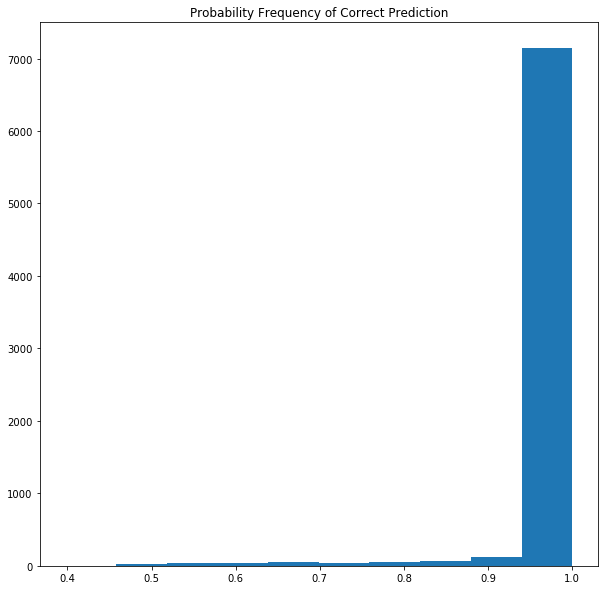

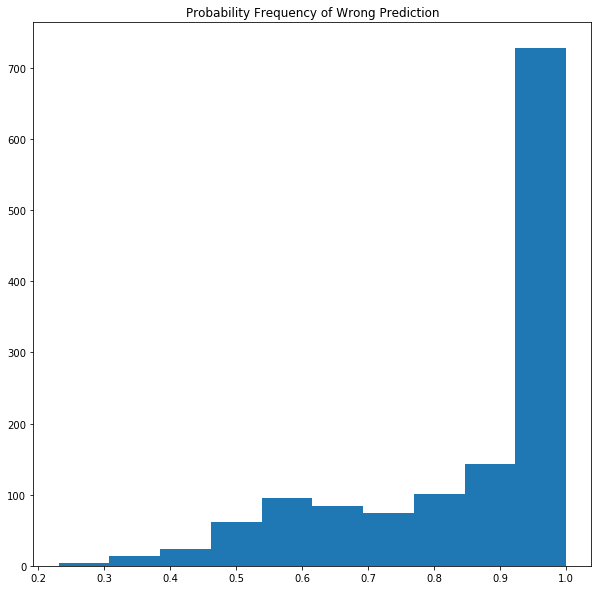

In [30]:
fig,ax = plt.subplots(figsize=(10,10))
#ax.hist(np.array([x[np.argsort(x)[::-1][0]] for x in pred]))
ax.hist(np.array([x[np.argsort(x)[::-1][0]] for x in pred[np.where(pred_class == test_labels)]]))
ax.set_title('Probability Frequency of Correct Prediction')
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(np.array([x[np.argsort(x)[::-1][0]] for x in pred[np.where(pred_class != test_labels)]]))
ax.set_title('Probability Frequency of Wrong Prediction')

Confusion matrix, without normalization


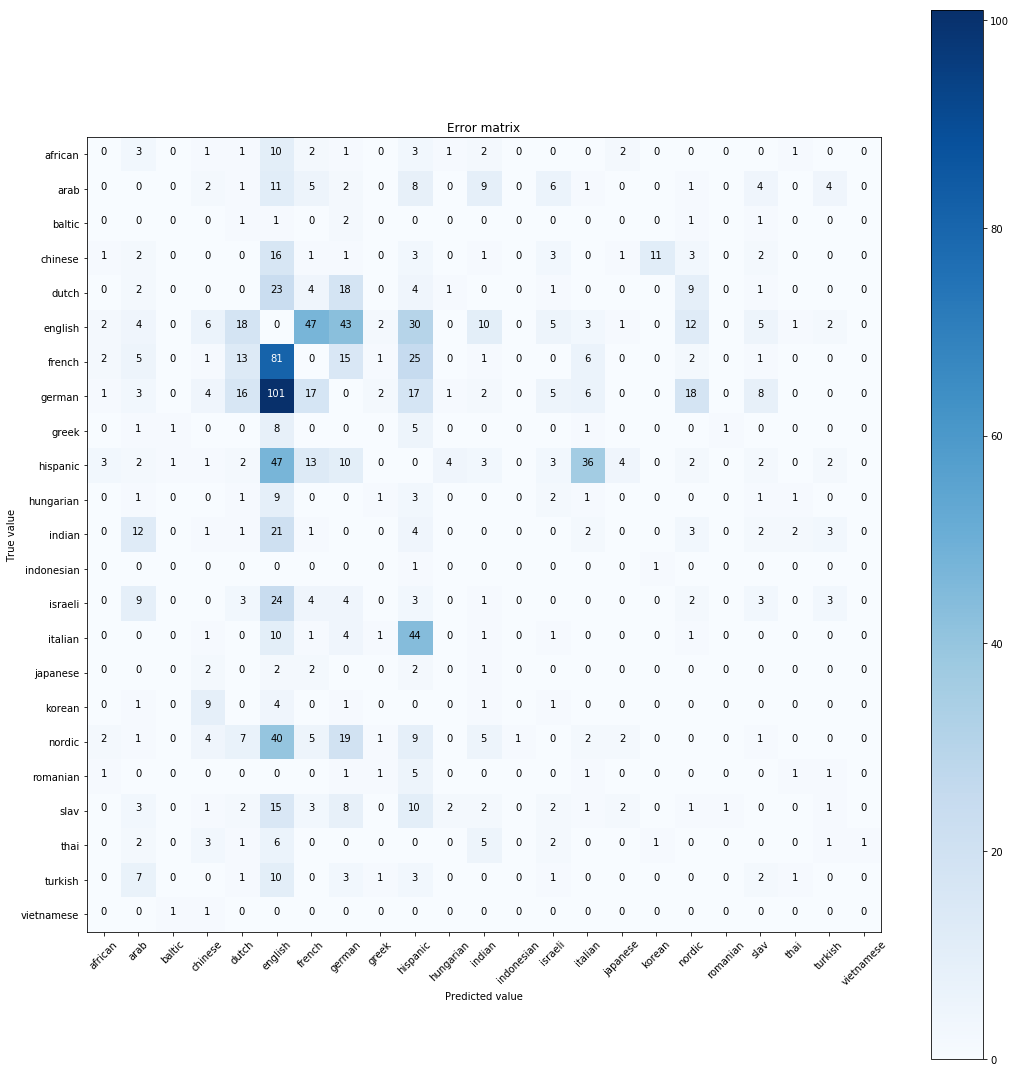

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Error matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()